# Data exploration

## Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import random
from shapely import geometry
import rasterio
from math import floor
import matplotlib.patches as patches

IMAGES_RGB_PATH = "data/AOI_3_Paris_Train/RGB-PanSharpen/"
COMMON_NAME_RGB = "RGB-PanSharpen_AOI_3_Paris_img"

GEOJSONS_PATH = "data/AOI_3_Paris_Train/geojson/buildings/"
COMMON_NAME_GEOJSONS = "buildings_AOI_3_Paris_img"

## Useful functions

In [25]:
def get_random_image():
    images_filenames = os.listdir(IMAGES_RGB_PATH)
    random_image_path = IMAGES_RGB_PATH + random.choice(images_filenames)
    index_image = random_image_path[len(IMAGES_RGB_PATH) + len(COMMON_NAME_RGB):-4]
    geojson_path = GEOJSONS_PATH + COMMON_NAME_GEOJSONS + index_image + ".geojson"
    return random_image_path, geojson_path
    

def gdal_to_rgb(ds):
    img = ds.ReadAsArray()
    img = np.transpose(img, (1, 2, 0))
    img = img.astype(np.float32)

    min_vals = np.min(img, axis=(0, 1))
    max_vals = np.max(img, axis=(0, 1))

    normalized_image = (img - min_vals) / (max_vals - min_vals)

    return (normalized_image * 255).astype(np.uint8)

def display_image(image_path):
    ds = gdal.Open(image_path)
    img = gdal_to_rgb(ds)
    plt.imshow(img)
    plt.axis('off')
    
    
def object_features(feature, ffa, aff):    
    poly = geometry.shape(feature['geometry'])
    center = poly.centroid
    x_center, y_center = ffa * (center.x, center.y)
    bbox = poly.bounds
    width = (bbox[2] - bbox[0]) // aff[0]
    height = (bbox[3] - bbox[1]) // -aff[4]
    out = ('obj_class', floor(x_center), floor(y_center), width, height)
    return out

# reference: https://gist.github.com/avanetten/534e6f341b0670be2ea74ce39d68226a#file-geojson_to_pixel_arr-py

from osgeo import gdal, osr, ogr
def latlon2pixel(lat, lon, input_raster='', targetsr='', geom_transform=''):
    # type: (object, object, object, object, object) -> object

    sourcesr = osr.SpatialReference()
    sourcesr.ImportFromEPSG(4326)

    geom = ogr.Geometry(ogr.wkbPoint)
    geom.AddPoint(lon, lat)

    if targetsr == '':
        src_raster = gdal.Open(input_raster)
        targetsr = osr.SpatialReference()
        targetsr.ImportFromWkt(src_raster.GetProjectionRef())
    coord_trans = osr.CoordinateTransformation(sourcesr, targetsr)
    if geom_transform == '':
        src_raster = gdal.Open(input_raster)
        transform = src_raster.GetGeoTransform()
    else:
        transform = geom_transform

    x_origin = transform[0]
    # print(x_origin)
    y_origin = transform[3]
    # print(y_origin)
    pixel_width = transform[1]
    # print(pixel_width)
    pixel_height = transform[5]
    # print(pixel_height)
    geom.Transform(coord_trans)
    # print(geom.GetPoint())
    x_pix = (geom.GetPoint()[0] - x_origin) / pixel_width
    y_pix = (geom.GetPoint()[1] - y_origin) / pixel_height

    return (x_pix, y_pix)


def geojson_to_pixel_arr(raster_file, geojson_file, pixel_ints=True,
                       verbose=False):
    '''
    Tranform geojson file into array of points in pixel (and latlon) coords
    pixel_ints = 1 sets pixel coords as integers
    '''
    
    # load geojson file
    with open(geojson_file) as f:
        geojson_data = json.load(f)

    # load raster file and get geo transforms
    src_raster = gdal.Open(raster_file)
    targetsr = osr.SpatialReference()
    targetsr.ImportFromWkt(src_raster.GetProjectionRef())
        
    geom_transform = src_raster.GetGeoTransform()
    
    # get latlon coords
    latlons = []
    types = []
    for feature in geojson_data['features']:
        coords_tmp = feature['geometry']['coordinates'][0]
        type_tmp = feature['geometry']['type']
        if verbose: 
            print("features:", feature.keys())
            print("geometry:features:", feature['geometry'].keys())

            #print "feature['geometry']['coordinates'][0]", z
        latlons.append(coords_tmp)
        types.append(type_tmp)
        #print feature['geometry']['type']
    
    # convert latlons to pixel coords
    pixel_coords = []
    latlon_coords = []
    for i, (poly_type, poly0) in enumerate(zip(types, latlons)):
        
        if poly_type.upper() == 'MULTIPOLYGON':
            #print "oops, multipolygon"
            for poly in poly0:
                poly=np.array(poly)
                if verbose:
                    print("poly.shape:", poly.shape)
                    
                # account for nested arrays
                if len(poly.shape) == 3 and poly.shape[0] == 1:
                    poly = poly[0]
                    
                poly_list_pix = []
                poly_list_latlon = []
                if verbose: 
                    print("poly", poly)
                for coord in poly:
                    if verbose: 
                        print("coord:", coord)
                    lon, lat, z = coord 
                    px, py = latlon2pixel(lat, lon, input_raster=src_raster,
                                         targetsr=targetsr, 
                                         geom_transform=geom_transform)
                    poly_list_pix.append([px, py])
                    if verbose:
                        print("px, py", px, py)
                    poly_list_latlon.append([lat, lon])
                
                if pixel_ints:
                    ptmp = np.rint(poly_list_pix).astype(int)
                else:
                    ptmp = poly_list_pix
                pixel_coords.append(ptmp)
                latlon_coords.append(poly_list_latlon)            

        elif poly_type.upper() == 'POLYGON':
            poly=np.array(poly0)
            if verbose:
                print("poly.shape:", poly.shape)
                
            # account for nested arrays
            if len(poly.shape) == 3 and poly.shape[0] == 1:
                poly = poly[0]
                
            poly_list_pix = []
            poly_list_latlon = []
            if verbose: 
                print("poly", poly)
            for coord in poly:
                if verbose: 
                    print("coord:", coord)
                lon, lat, z = coord 
                px, py = latlon2pixel(lat, lon, input_raster=src_raster,
                                     targetsr=targetsr, 
                                     geom_transform=geom_transform)
                poly_list_pix.append([px, py])
                if verbose:
                    print("px, py", px, py)
                poly_list_latlon.append([lat, lon])
            
            if pixel_ints:
                ptmp = np.rint(poly_list_pix).astype(int)
            else:
                ptmp = poly_list_pix
            pixel_coords.append(ptmp)
            latlon_coords.append(poly_list_latlon)
            
        else:
            print("Unknown shape type in coords_arr_from_geojson()")
            return
            
    return pixel_coords, latlon_coords

## Dataset exploring

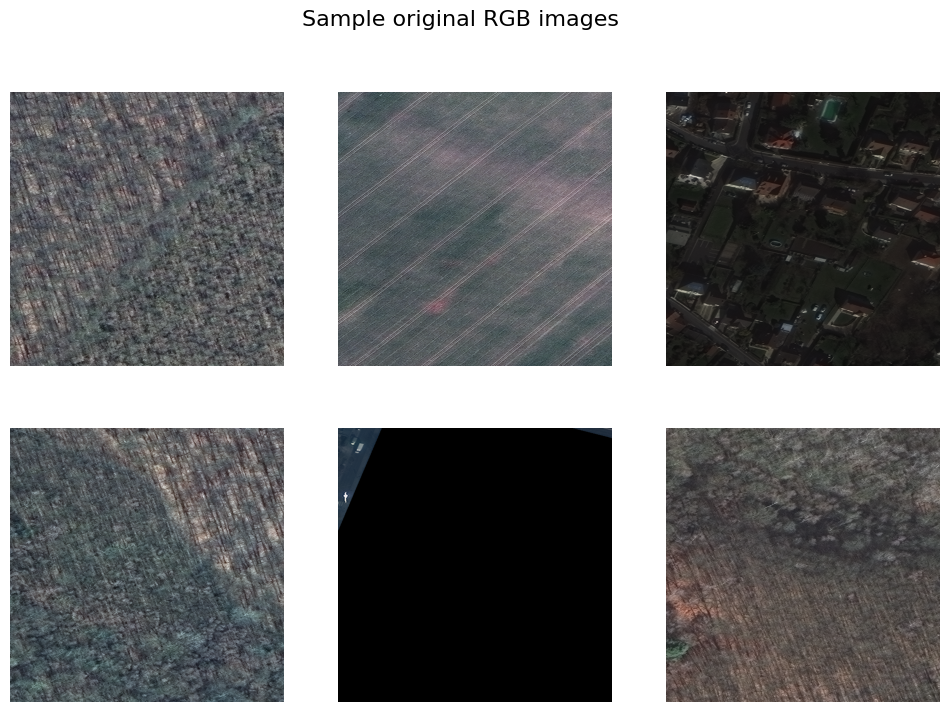

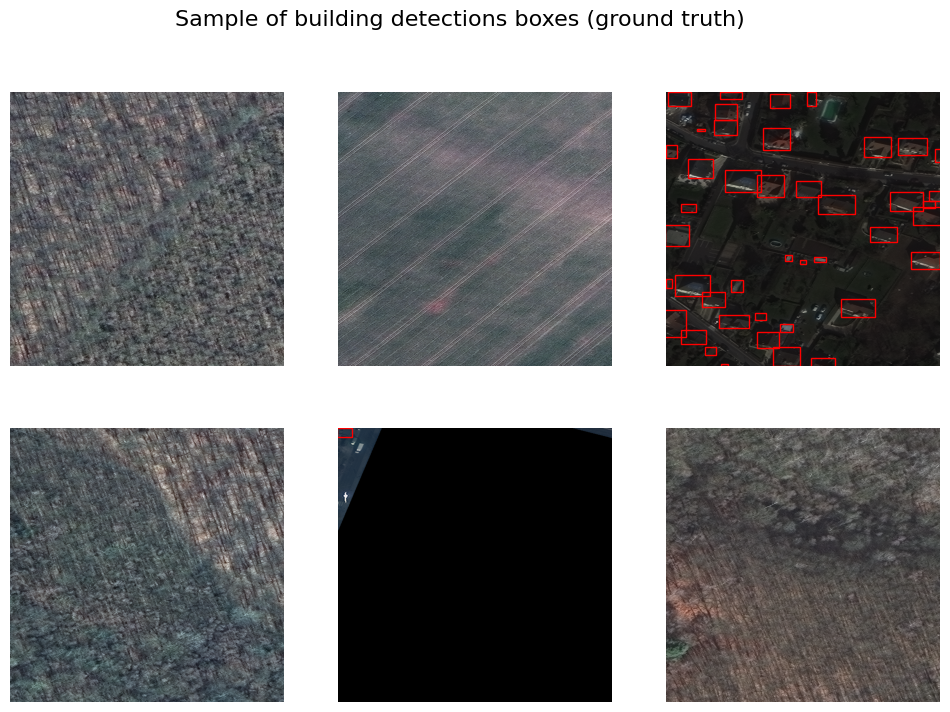

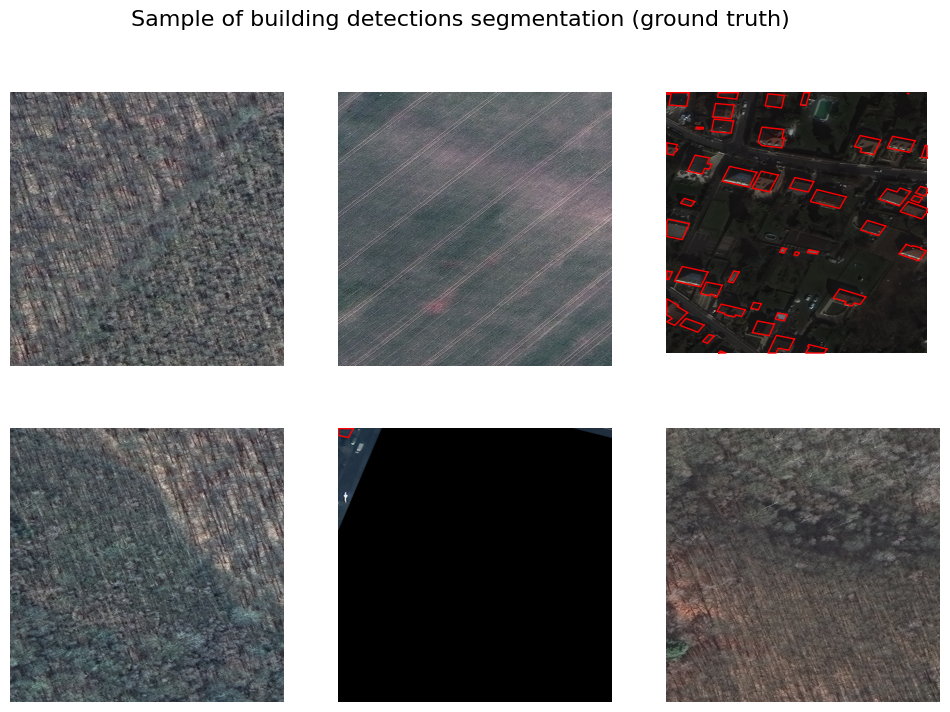

In [31]:
plt.figure(figsize=(12, 8))
grid_spec = plt.GridSpec(2, 3, width_ratios=[1, 1, 1])
images_random = [get_random_image() for i in range(6)]

plt.suptitle("Sample original RGB images", fontsize=16)
for i, (image_path, geo_file) in enumerate(images_random):
    plt.subplot(grid_spec[i])
    display_image(image_path)

plt.figure(figsize=(12, 8))
grid_spec = plt.GridSpec(2, 3, width_ratios=[1, 1, 1])

for i, (image_path, geo_file) in enumerate(images_random):
    ax = plt.subplot(grid_spec[i])
    
    with open(geo_file) as src:
        fc = json.load(src)

    with rasterio.open(image_path) as src:
        aff = src.transform
    
    ffa = ~aff
    
    bb_list = [object_features(feat, ffa, aff) for feat in fc['features']]

    ds = gdal.Open(image_path)
    img = gdal_to_rgb(ds)
    ax.imshow(img)
    ax.axis('off')
    
    for bb in bb_list:
        obj_class, x_center, y_center, width, height = bb
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
plt.suptitle("Sample of building detections boxes (ground truth)", fontsize=16)




plt.figure(figsize=(12, 8))
grid_spec = plt.GridSpec(2, 3, width_ratios=[1, 1, 1])

plt.suptitle("Sample original RGB images", fontsize=16)
for i, (image_path, geo_file) in enumerate(images_random):
    plt.subplot(grid_spec[i])
    display_image(image_path)
    
    geo_data = geojson_to_pixel_arr(image_path, geo_file, pixel_ints=True,
                       verbose=False)

    geo_data_pix_coords = geo_data[0]
    
    for polygon in geo_data_pix_coords:
        x_coords = polygon[:, 0]
        y_coords = polygon[:, 1]
        plt.plot(x_coords, y_coords, 'r-', linewidth=1)
        
plt.suptitle("Sample of building detections segmentation (ground truth)", fontsize=16)
plt.show()